In [1]:
import fastai
import fastai.utils.collect_env
fastai.utils.collect_env.show_install(1)



```text
=== Software === 
python        : 3.6.6
fastai        : 1.0.54
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.9.0-8-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.144-3.1 (2019-02-19)
conda env     : Unknown
python        : /opt/conda/bin/python
sys.path      : /kaggle/lib/kagglegym
/kaggle/lib
/opt/conda/lib/python36.zip
/opt/conda/lib/python3.6
/opt/conda/lib/python3.6/lib-dynload

/root/.local/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages/nolearn-0.6.1.dev0-py3.6.egg
/opt/conda/lib/python3.6/site-packages/tabulate-0.8.3-py3.6.egg
/opt/conda/lib/python3.6/site-packages/gdbn-0.1-py3.6.egg
/opt/conda/lib/python3.6/site-packages/gnumpy-0.2-py3.6.egg
/opt/conda/lib

In [2]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/tmp/.fastai/data/mnist_png/training'),
 PosixPath('/tmp/.fastai/data/mnist_png/testing')]

### Creating a data bunch, one line at a time

In [5]:
# convert mode = 'L' stands for grayscale
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/tmp/.fastai/data/mnist_png/training/2/26899.png')

In [7]:
# when we show() images it usually shows them in RGB color map
# we need to set it to binary
defaults.cmap='binary'

In [8]:
# images are 1,28,28 because PyTorch puts channels first and
# we will be working with rank3 tensors later so it's easier to add
# a unit axis from the start and keep
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /tmp/.fastai/data/mnist_png

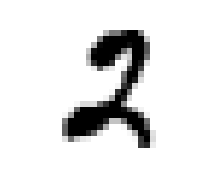

In [9]:
il[0].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /tmp/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /tmp/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/tmp/.fastai/data/mnist_png/training/2'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/8'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/4'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/7'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/5'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/6'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/0'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/1'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/9'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/3')]

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,2,2,2,2
Path: /tmp/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,2,2,2,2
Path: /tmp/.fastai/data/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

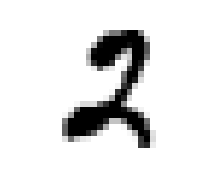

In [16]:
x.show()

In [17]:
y

Category 2

In [18]:
# we don't do the normal transforms cuz flipping or rotating will change the meaning
# we also avoid zooms and crops because the images are small
# the empty list at the end means no transforms on the validation set
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [19]:
ll = ll.transform(tfms)

In [20]:
bs = 128

In [21]:
# we don't normalize with imagenet stats because we're not using pretrained model
data = ll.databunch(bs=bs).normalize()

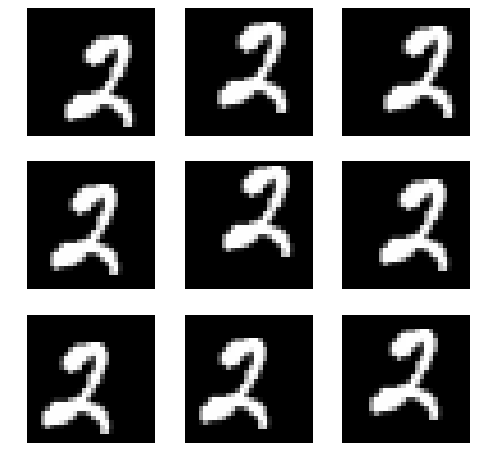

In [22]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [23]:
xb,yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

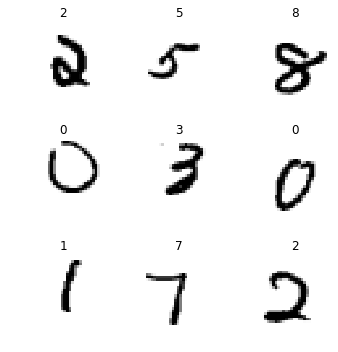

In [24]:
data.show_batch(rows=3, figsize=(5,5))

In [25]:
?nn.Conv2d

# in channels
# out channels
# kernel size
# stride
# padding

In [26]:
# if we want to do something over and over again it'll be better to do it as a func
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size = 3, stride = 2, padding = 1)

In [27]:
# conv(1,8)
# 1 = in channels = flattened images
# 8 = out channels = no of kernels
# kernel size = 3
# stride = 2, since stride is 2 we keep doubling the number of kernels

model = nn.Sequential(
        conv(1,8), # grid size 14 * 14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        conv(8,16), # grid size 7 * 7
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16, 32), # grid size 4 * 4
        nn.BatchNorm2d(32),
        nn.ReLU(),
        conv(32,16), # grid size 2 * 2
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16,10), # grid size 1 * 1
        nn.BatchNorm2d(10),
        Flatten() # final output would be 10 * 1 * 1, flatten removes the (1,1)
        )

In [28]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics = accuracy)

In [29]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [30]:
# put the mini batch on the gpu
xb = xb.cuda()

In [31]:
# we can now use the model as a function
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


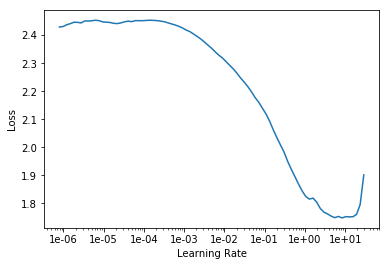

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.254699,0.308537,0.902900,00:32
1,0.137037,0.114005,0.963700,00:30
2,0.078402,0.042361,0.986800,00:30


## Refactor

In [35]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [36]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [37]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.231589,0.196443,0.938000,00:29
1,0.200227,0.220248,0.936100,00:28
2,0.162766,0.085390,0.972400,00:28
3,0.143742,0.210946,0.931700,00:28
4,0.122877,0.086052,0.973700,00:28
5,0.094019,0.067030,0.979900,00:28
6,0.087904,0.068200,0.979500,00:28
7,0.072469,0.040435,0.987700,00:28
8,0.054215,0.029126,0.990700,00:28
9,0.046315,0.027801,0.991400,00:28


## ResNet - ish

If we want to make our current network dense we can do so by adding a bunch of stride 1 convolutions in between because they don't change the size of the grid. But researchers have tried this and reported the results in [this paper](https://arxiv.org/abs/1512.03385). They found that a 56 layer network with stride 1 convs in between did not work better (did not overfit) than a 20 layer network with just stride 2 convs. In fact it did worse.

-- insert image

What they did then was to try and convert the 56 layer network into something as good as the 20 layer one. For every two convolutions, they add the input of the conv with the output of the 2 convs. So instead of:

`output = conv2(conv1(x))`

we do

`output = x + conv2(conv1(x))`

In [39]:
from fastai.layers import *

In [40]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [41]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [42]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [43]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


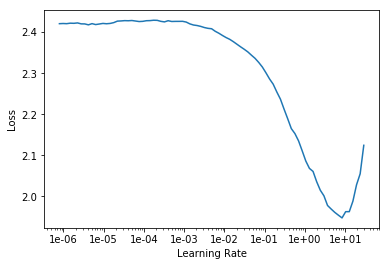

In [45]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.258279,0.193537,0.944200,00:32
1,0.130323,0.135954,0.955900,00:32
2,0.096199,0.138355,0.954700,00:32
3,0.080895,0.062652,0.980900,00:32
4,0.079793,0.093072,0.971600,00:32
5,0.067633,0.060408,0.981000,00:32
6,0.057093,0.032065,0.990600,00:32
7,0.044021,0.034554,0.989000,00:32
8,0.032127,0.026078,0.991200,00:31
9,0.028238,0.019349,0.993600,00:32


In [47]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## Dense net

If we set `dense = True` in resblock then we get a dense net. In dense net instead of adding the i/p we concatenate it with the output of the 2 conv layers.